In [87]:
import numpy as np
import pandas as pd
from astropy.table import Table
from astropy.constants import G
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import rc
rc('text', usetex=True)
rc('xtick', labelsize=20)
rc('ytick', labelsize=20)
from scipy.optimize import minimize

In [ ]:
# =======================================

def bin_data(x, bins):
    dN = np.zeros(bins.shape[0])
    dD = bins[1] - bins[0]
    for i, dbin in enumerate(bins):
        dN[i] = len(np.where((x > dbin) & (x < dbin+dD))[0])
    return dN

In [2]:
data = Table.read('Astr511HW1data.dat.gz', format='ascii')

In [3]:
u = np.array(data['u'])
g = np.array(data['g'])
r = np.array(data['r'])
i = np.array(data['i'])
z = np.array(data['z'])

u_g = u - g
g_r = g - r
g_i = g - i

x = u_g
y = g_r

Compute photometric absolute magnitudes and metallicities using the following relations:

$$\Delta{M_r}([\textrm{Fe}/\textrm{H}]) = 4.50 - 1.11[\textrm{Fe}/\textrm{H}] - 0.18[\textrm{Fe}/\textrm{H}]^2$$

$${M_r}(g-i,[\textrm{Fe}/\textrm{H}]) = M_r^0(g-i) + \Delta{M_r}([\textrm{Fe}/\textrm{H}])$$

$$([\textrm{Fe}/\textrm{H}]) =  A + Bx + Cy + Dxy + Ex^2 + Fy^2 + Gx^2y + Hxy^2 + Ix^3 + Jy^3$$

In [4]:
ndata = x.shape[0]

# Calculate photometric metallicities
A_J = np.array([-13.13, 14.09, 28.04, -5.51, -5.90, -58.68, 9.14, -20.61, 0.0, 58.20])
features = np.array([np.ones(ndata), x, y, x*y, x**2, y**2, x**2*y, x*y**2, x**3, y**3])

feh = np.dot(A_J, features)

feh[np.where(y > 0.6)[0]] = -0.6

In [5]:
# Calculate absolute magnitude
M_r0 = -5.06 + 14.32*g_i - 12.97*g_i**2 + 6.127*g_i**3 - 1.267*g_i**4 + 0.0967*g_i**5
dM_r = 4.50 - 1.11*feh - 0.18*feh**2
M_r  = M_r0 + dM_r

# Calculate distance
D = 10**((r - M_r)/5 + 1)
Z = D

In [38]:
df = pd.DataFrame(data={'g_r':g_r, 'feh':feh, 'M_r':M_r, 'D':Z/1e3, 'r':r})

### Question 1

Make color cut 0.2 < g-r < 0.4, bin sample by distance, and compute volume for each distance bin, where the differential volume for a slice of a sphere is given by 

$$dV = \Delta\Omega * D^2 *dD $$

Integrating over the distance bin gives the volume for the bin:

$$\Delta V = \frac{1}{3} \Delta \Omega \left((D + \Delta D)^3 - D^3 \right) $$

In [185]:
# Solid angle bin
dOmega = 314 / (180/np.pi)**2  # convert deg^2 to sterradians
dD = .25
maxD = 26

# Create distance bins, and calculate volume of each distance bin
Dbins = np.arange(0,maxD,dD)
Dbin_cent = np.arange(dD/2,maxD,dD)
dV = dOmega * ((Dbins + dD)**3 - Dbins**3) / 3

# Apply g-r color cut
gr_bin = [0.2, 0.4]
sel = df[df['g_r'] < gr_bin[1]][df['g_r'] > gr_bin[0]]

# Calculate number of stars per distance bin
dN = np.zeros(Dbins.shape[0])
for i, dbin in enumerate(Dbins):
    dN[i] = len(np.where((sel['D'] > dbin) & (sel['D'] < dbin+dD))[0])

/nvme/cache/epyc/opt/anaconda-2019/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


Plot of density as a function of distance:

/nvme/cache/epyc/opt/anaconda-2019/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


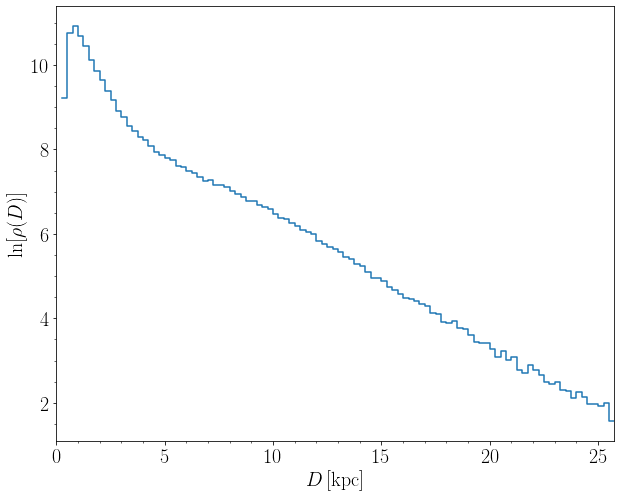

In [154]:
plt.figure(figsize=[10,8])
plt.step(Dbins, np.log(dN/dV))
plt.ylabel(r'$\ln[\rho(D)]$', fontsize=20)
plt.xlabel(r'$D \, \rm [kpc]$', fontsize=20)
plt.xlim(min(Dbins), max(Dbins))
# plt.yscale('log')
plt.minorticks_on()
plt.savefig('plot1.png')
plt.show()

What is the Z range where you believe the results for ρ(Z), and why?

/nvme/cache/epyc/opt/anaconda-2019/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


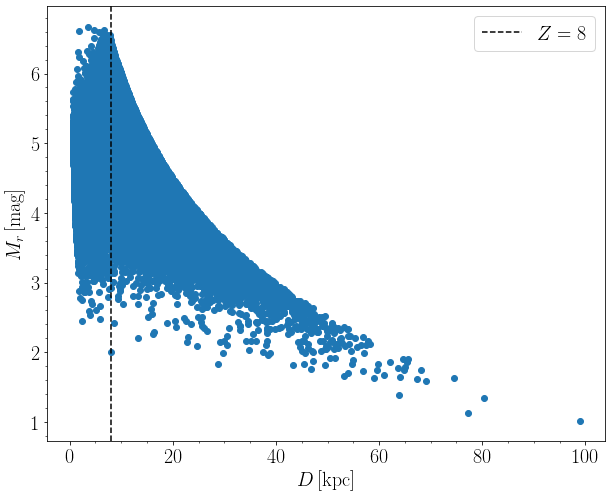

In [155]:
# Apply g-r color cut
gr_bin = [0.2, 0.4]
sel = df[df['g_r'] < gr_bin[1]][df['g_r'] > gr_bin[0]]

plt.figure(figsize=[10,8])
plt.scatter(sel['D'], sel['M_r'])
plt.ylabel(r'$M_r \, \rm [mag]$', fontsize=20)
plt.xlabel(r'$D \, \rm [kpc]$', fontsize=20)
plt.axvline(x=8, color='k', linestyle='--', label=r'$Z=8$')
plt.legend(fontsize=20)
plt.minorticks_on()
# plt.xscale('log')
plt.show()

From this plot it appears we become flux limited around $Z\sim 8$, since fainter absolute magnitudes begin falling off sharply as they become too faint to detect for $Z>8$.

### Question 2

/nvme/cache/epyc/opt/anaconda-2019/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/nvme/cache/epyc/opt/anaconda-2019/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/nvme/cache/epyc/opt/anaconda-2019/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/nvme/cache/epyc/opt/anaconda-2019/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/nvme/cache/epyc/opt/anaconda-2019/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/nvme/cache/epyc/opt/anaconda-2019/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/

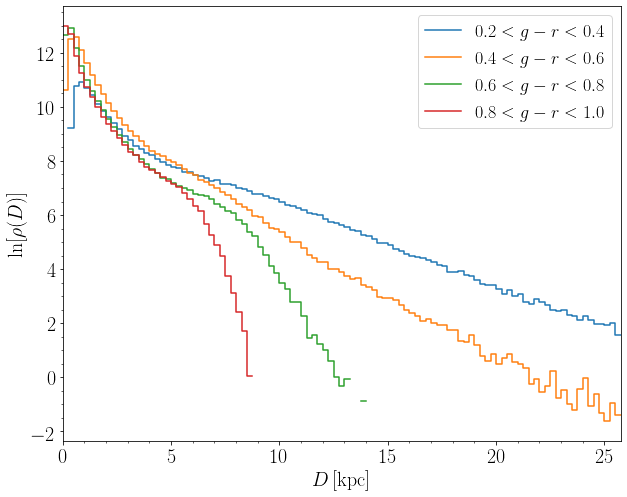

In [186]:
color_bins = [[0.2, 0.4], [0.4, 0.6], [0.6, 0.8], [0.8, 1.0]]

plt.figure(figsize=[10,8])
for gr_bin in color_bins:
    sel = df[df['g_r'] < gr_bin[1]][df['g_r'] > gr_bin[0]]

    # Calculate number of stars per distance bin
    dN = np.zeros(Dbins.shape[0])
    for i, dbin in enumerate(Dbins):
        dN[i] = len(np.where((sel['D'] > dbin) & (sel['D'] < dbin+dD))[0])
        
    plt.step(Dbins, np.log(dN/dV), label=r'$%s < g-r < %s$'%(gr_bin[0], gr_bin[1]))
    
plt.ylabel(r'$\ln[\rho(D)]$', fontsize=20)
plt.xlabel(r'$D \, \rm [kpc]$', fontsize=20)
plt.xlim(min(Dbins), max(Dbins))
# plt.yscale('log')
plt.legend(loc='upper right', fontsize=18)
plt.minorticks_on()
plt.savefig('plot2.png')
plt.show()

Breaking our sample down by color bins, we note that sources with higher g-r colors have lower temperatures, so they are intrinsically fainter and thus harder to detect at further distances. So the fact that lower number densities of redder stars are detected at further distances is not necessarily because the density decreases, but also because their faint brightnesses become undetectable by the instrument

### Question 3

/nvme/cache/epyc/opt/anaconda-2019/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


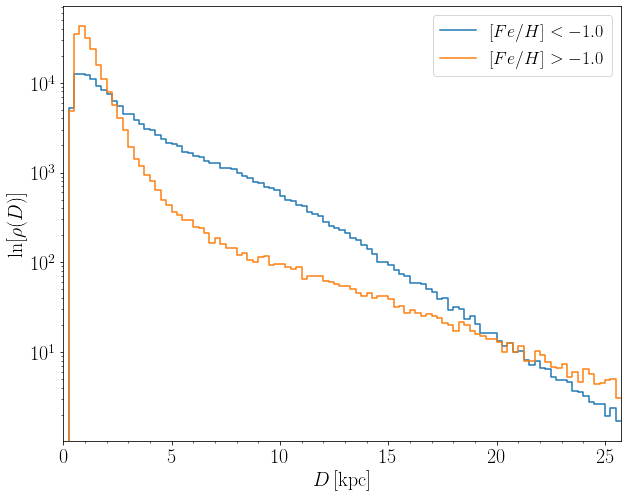

In [184]:
# Apply g-r color cut
gr_bin = [0.2, 0.4]
sel = df[df['g_r'] < gr_bin[1]][df['g_r'] > gr_bin[0]]

low_feh  = sel[sel['feh'] < -1.0]
high_feh = sel[sel['feh'] > -1.0]

dN_high = np.zeros(Dbins.shape[0])
for i, dbin in enumerate(Dbins):
    dN_high[i] = len(np.where((high_feh['D'] > dbin) & (high_feh['D'] < dbin+dD))[0])
    
dN_low = np.zeros(Dbins.shape[0])
for i, dbin in enumerate(Dbins):
    dN_low[i] = len(np.where((low_feh['D'] > dbin) & (low_feh['D'] < dbin+dD))[0])
  
plt.figure(figsize=[10,8])
plt.step(Dbins, dN_low/dV, label=r'$[Fe/H]<-1.0$')
plt.step(Dbins, dN_high/dV, label=r'$[Fe/H]>-1.0$')
    
plt.ylabel(r'$\ln[\rho(D)]$', fontsize=20)
plt.xlabel(r'$D \, \rm [kpc]$', fontsize=20)
plt.xlim(min(Dbins), max(Dbins))
plt.yscale('log')
plt.legend(loc='upper right', fontsize=18)
plt.minorticks_on()
plt.savefig('plot3.png')
plt.show()

As distance increases, we observe that there is a higher fraction of low metallicity stars than high metallicity. This is because the halo (population at higher distances) is an older population of stars, and thus more metal poor.

At higher distances (>20 kpc), we see that there are higher high-metallicity stars than low metalicity stars. This is likely due to contamination from disk stars due to higher photometric metallicity errors for distant (faint) sources.

### Question 4

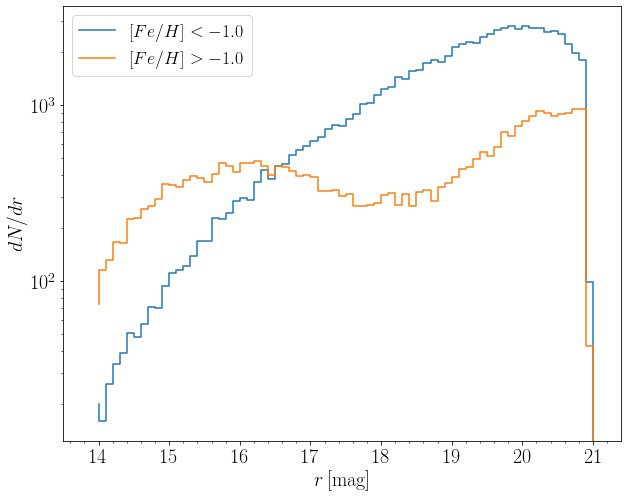

In [180]:
dr = .1
rbins = np.arange(14,21.5,dr)

dN_high = np.zeros(rbins.shape[0])
for i, rbin in enumerate(rbins):
    dN_high[i] = len(np.where((high_feh['r'] > rbin) & (high_feh['r'] < rbin+dr))[0])
    
dN_low = np.zeros(rbins.shape[0])
for i, rbin in enumerate(rbins):
    dN_low[i] = len(np.where((low_feh['r'] > rbin) & (low_feh['r'] < rbin+dr))[0])

plt.figure(figsize=[10,8])
plt.step(rbins, dN_low, label=r'$[Fe/H]<-1.0$')
plt.step(rbins, dN_high, label=r'$[Fe/H]>-1.0$')
    
plt.ylabel(r'$dN/dr$', fontsize=20)
plt.xlabel(r'$r \, \rm [mag]$', fontsize=20)
plt.xlim(min(rbins)-.5, max(rbins))
plt.yscale('log')
plt.legend(loc='upper left', fontsize=18)
plt.minorticks_on()
plt.savefig('plot4.png')
plt.show()

For the high metallicity sample (tracing the disk), we see that the curve peaks around $r\sim 16$ corresponding to the scale height of the disk, then decreases for $r>16$. We would expect that the high metallicity curve would continue to decrease as a function of increasing r, but we find that is a second peak at $r\sim21$, which is due to high photometric metallicity errors for faint sources ($r>18$).

For the low metallicity sample (tracing the halo), we observe that the sample increases as a function of magnitude, as far out halo sources are fainter.

### Question 5

First we compute the galactocentric radius for each star in the sample
$$ R = \sqrt{8^2 + Z^2} $$
where we assume the distance from the sun's position to the galactic center is 8 kpc and Z is the vertical height perpendicular to the disk.

In [175]:
# Galactocentric radius
df['R'] = np.sqrt(8**2 + df['D']**2)
minR = 9.0
maxR = 10.5
dR = .05

# Create distance bins, and calculate volume of each distance bin
Rbins = np.arange(minR,maxR,dR)
Dbins = np.sqrt(Rbins**2 - 8**2)
dV = dOmega * ((Dbins + dD)**3 - Dbins**3) / 3

Because we want to examine the stellar density dependence as a function of R for halo stars, we apply cuts on Z and [Fe/H] to select for halo stars:
$$ 4 < Z < 7 $$
$$ [Fe/H] < -1.0 $$
in addition to color cut $ 0.2 < g-r < 0.4 $

In [176]:
# Apply g-r color cut
gr_bin = [0.2, 0.4]
sel = df[df['g_r'] < gr_bin[1]][df['g_r'] > gr_bin[0]]

# Apply cut to only stars which are captured by flux limit of the instrument
sel = sel[sel['D'] < 7][sel['D'] > 4] # halo mostly between 5-7

# Apply metallicity cut
sel = sel[sel['feh'] < -1.0]

# Calculate number of stars per distance bin
dN = np.zeros(Rbins.shape[0])
for i, dbin in enumerate(Rbins):
    dN[i] = len(np.where((sel['R'] > dbin) & (sel['R'] < dbin+dR))[0])
    
rho = dN/dV

/nvme/cache/epyc/opt/anaconda-2019/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/nvme/cache/epyc/opt/anaconda-2019/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


We assume a halo stellar density model in which $\rho(R)$ is proportional to $1/R^3$. To fit the model to the selected sample we solve for the proportionality constant A in the equation model $\rho(R) = A/R^3$ using scipy to optimize the least squares fit:

In [177]:
def rho_model(A):
    return A/Rbins**3

def fit_mse(A):
    return np.sum((rho_model(A) - rho)**2)

In [178]:
soln = minimize(fit_mse, rho[0])
soln

      fun: 687056.9989786886
 hess_inv: array([[13433.87844559]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 60
      nit: 5
     njev: 20
   status: 0
  success: True
        x: array([671155.33161948])

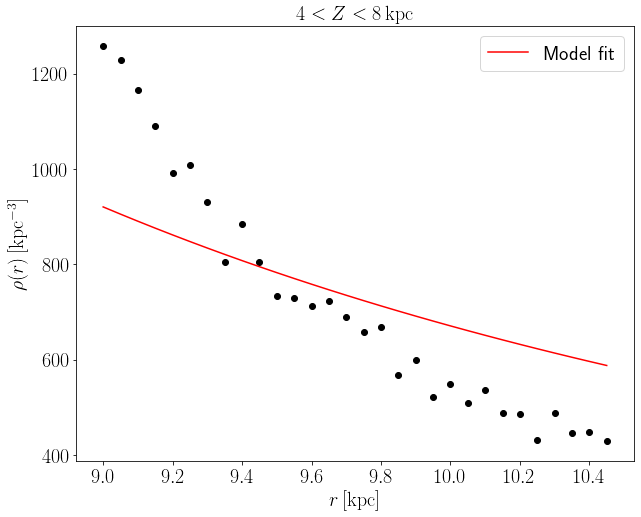

In [179]:
plt.figure(figsize=[10,8])
plt.scatter(Rbins, rho, color='k')
plt.plot(Rbins, rho_model(soln.x[0]), color='r', label='Model fit')
plt.ylabel(r'$\rho(r) \, \rm [kpc^{-3}]$', fontsize=20)
plt.xlabel(r'$r \, \rm [kpc]$', fontsize=20)
plt.title(r'$4 < Z < 8 \, \rm kpc$', fontsize=20)
plt.legend(loc='upper right', fontsize=20)
plt.savefig('plot5.png')
# plt.yscale('log')
plt.show()

We find that our observed halo sample density (in black) follows a steeper r relation than can be described by a $\rho(R) \propto 1/R^3$ relation (red).